Team :
- Sai Gowtham Dasappa Ravindra,
- Abhishict Pamula,
- Rohit Reddy Peddi,
- Sai Srinivasa Subrahmanyam Puranam,
- Bhuvanendra Putchala

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations
from collections import Counter

In [ ]:
import warnings

warnings.filterwarnings("ignore")



In [ ]:
!wget https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip

--2023-12-19 04:59:41--  https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip
Resolving cdn.stackoverflow.co (cdn.stackoverflow.co)... 35.190.70.79, 2600:1901:0:546a::
Connecting to cdn.stackoverflow.co (cdn.stackoverflow.co)|35.190.70.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20599404 (20M) [application/zip]
Saving to: ‘stack-overflow-developer-survey-2023.zip’

stack-overflow-deve 100%[===================>]  19.64M  8.70MB/s    in 2.3s    

2023-12-19 04:59:44 (8.70 MB/s) - ‘stack-overflow-developer-survey-2023.zip’ saved [20599404/20599404]



In [ ]:
!unzip stack-overflow-developer-survey-2023.zip

Archive:  stack-overflow-developer-survey-2023.zip
  inflating: README_2023.txt         
  inflating: so_survey_2023.pdf      
  inflating: survey_results_public.csv  
  inflating: survey_results_schema.csv  


In [ ]:
df = pd.read_csv('/content/survey_results_public.csv')

In [ ]:
df.shape

(89184, 84)

In [ ]:
df.isnull().sum()

ResponseId                 0
Q120                       0
MainBranch                 0
Age                        0
Employment              1286
                       ...  
ProfessionalTech       47401
Industry               52410
SurveyLength            2699
SurveyEase              2630
ConvertedCompYearly    41165
Length: 84, dtype: int64

In [ ]:
cols_to_select = ['Age', 'Employment','CodingActivities', 'EdLevel', 'YearsCode',
                      'DevType','Country', 'ConvertedCompYearly', 'LanguageHaveWorkedWith',
                  'LanguageWantToWorkWith','Industry', 'WorkExp']

In [ ]:
df=df[cols_to_select]

In [ ]:
df.shape

(89184, 12)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(26127, 12)

Mapping countries with value Other which are having count less than threshold value 500

In [ ]:
def clean_countries_column(categories,cutoff):
  categories_map = {}
  for i in range(len(categories)):
      if categories.values[i]>=cutoff:
          categories_map[categories.index[i]] = categories.index[i]
      else:
          categories_map[categories.index[i]] = 'Other'
  return categories_map

In [ ]:
country_map = clean_countries_column(df['Country'].value_counts(),500)
df["Country"] = df["Country"].map(country_map)

In [ ]:
df["Country"].value_counts()

Other                                                   8118
United States of America                                6330
Germany                                                 2167
United Kingdom of Great Britain and Northern Ireland    1832
India                                                   1262
Canada                                                  1104
France                                                   876
Brazil                                                   750
Poland                                                   738
Netherlands                                              681
Australia                                                601
Spain                                                    592
Italy                                                    572
Sweden                                                   504
Name: Country, dtype: int64

In [ ]:
df.shape

(26127, 12)

In [ ]:
df.isnull().sum()

Age                       0
Employment                0
CodingActivities          0
EdLevel                   0
YearsCode                 0
DevType                   0
Country                   0
ConvertedCompYearly       0
LanguageHaveWorkedWith    0
LanguageWantToWorkWith    0
Industry                  0
WorkExp                   0
dtype: int64

Mapping years of coding exprience which are having less than 1 year with 1 and more than 50 years of exprience with 51 for better processing  and converting data type to int

In [ ]:
df["YearsCode"]=df["YearsCode"].replace({
    "Less than 1 year":"1",
    "More than 50 years":"51"})

In [ ]:
df["YearsCode"]=df["YearsCode"].astype("int")

In [ ]:
df["DevType"].value_counts()

Developer, full-stack                            9241
Developer, back-end                              5665
Developer, front-end                             1754
Developer, desktop or enterprise applications    1258
Developer, mobile                                 935
Other (please specify):                           776
Engineering manager                               754
Developer, embedded applications or devices       742
DevOps specialist                                 545
Data scientist or machine learning specialist     519
Engineer, data                                    474
Research & Development role                       453
Senior Executive (C-Suite, VP, etc.)              439
Cloud infrastructure engineer                     416
Academic researcher                               296
Developer, game or graphics                       209
Developer, QA or test                             202
Engineer, site reliability                        193
Data or business analyst    

(0.0, 300000.0)

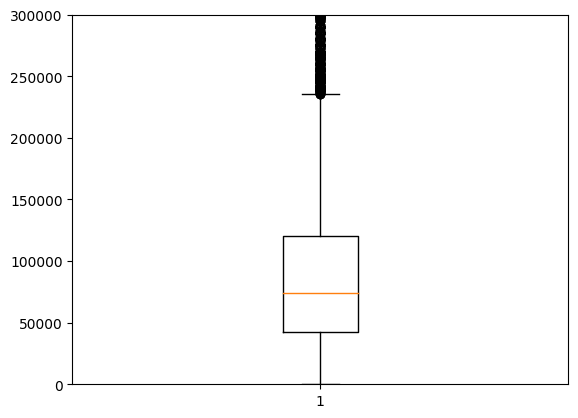

In [ ]:
plt.boxplot(df["ConvertedCompYearly"])
plt.ylim(0,300000)

Prefer Not to say values from Age column are removed

"Primary/elementary school" and "Something else" values in education level are removed as they create bias

Salaries that are above 225000 are removed as most of the data re having salaries in between 80,000 to 1,75,000

In [ ]:
df=df.drop(df.loc[df["Age"]=="Prefer not to say"].index)

df=df.drop(df.loc[df["EdLevel"]=="Something else"].index)

df=df.drop(df.loc[df["EdLevel"]=="Primary/elementary school"].index)

df=df.drop(df.loc[df["ConvertedCompYearly"]>225000].index)

df=df.drop(df.loc[df["ConvertedCompYearly"]<1000].index)

In [ ]:
df["ConvertedCompYearly"].describe()

count     24163.000000
mean      81243.944461
std       51886.346004
min        1000.000000
25%       42836.000000
50%       72000.000000
75%      111724.000000
max      225000.000000
Name: ConvertedCompYearly, dtype: float64

Developer in Industry are removed which are having values "Other"

In [ ]:
df=df.drop(df.loc[df["Industry"]=="Other"].index)

In [ ]:
df.shape

(21502, 12)

Age groups are being mapped with new range of ages

In [ ]:
def partition_exp(yrs):

  if yrs >=0 and yrs < 4:
    return '0 - 4 yrs exp'

  elif yrs >=4 and yrs < 6:
    return '4 - 6 yrs exp'

  elif yrs >=6 and yrs < 8:
    return '6 - 8 yrs exp'

  elif yrs >=8 and yrs < 10:
    return '8 - 10 yrs exp'

  elif yrs >=10 and yrs < 15:
    return '10 - 15 yrs exp'

  elif yrs >=15 and yrs < 20:
    return '15 - 20 yrs exp'

  elif yrs >=20 and yrs < 30:
    return '20 - 30 yrs exp'

  else:
    return '30+ yrs'

In [ ]:
df['CodeExp'] = df['YearsCode'].apply(partition_exp)

Below are the major values being mapped with consistent values with in range

In [ ]:
def get_education_details(degree):

  if 'Bachelor’s' in degree:
    return 'Bachelor’s'

  elif 'Master’s' in degree:
    return 'Master’s'

  elif degree == 'Some college/university study without earning a degree':
    return 'No Degree Yet'

  elif 'Professional' in degree:
    return 'Professional'

  elif 'Associate' in degree:
    return 'Associate'

  elif 'school' in degree:
    return 'school'

  else:
    return 'Other'

In [ ]:
df['Education Level'] = df['EdLevel'].apply(get_education_details)

In [ ]:
df.columns

Index(['Age', 'Employment', 'CodingActivities', 'EdLevel', 'YearsCode',
       'DevType', 'Country', 'ConvertedCompYearly', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'Industry', 'WorkExp', 'CodeExp',
       'Education Level'],
      dtype='object')

0 years of work experience are removed as they are irrelevant to present job role

In [ ]:
df=df.drop(df.loc[df["WorkExp"]==0].index)

In [ ]:
df["Employment"].value_counts()

Employed, full-time                                                                             18162
Employed, full-time;Independent contractor, freelancer, or self-employed                         1672
Independent contractor, freelancer, or self-employed                                              968
Employed, part-time                                                                               368
Independent contractor, freelancer, or self-employed;Employed, part-time                           97
Employed, full-time;Employed, part-time                                                            75
Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time       54
Employed, full-time;Retired                                                                         4
Employed, full-time;Independent contractor, freelancer, or self-employed;Retired                    2
Independent contractor, freelancer, or self-employed;Retired                      

Years of coding exprience is mapped into two categories below and above 10y

In [ ]:
def get_exp_group(yrs):

  n = int(yrs/10)
  if n == 0:
    n = 1
  output = f"{n*10}-{(n+1)*10} yrs"
  return output

In [ ]:
df['YrsGrp'] = df['WorkExp'].apply(get_exp_group)

Employement types are mapped into several categories like Full Time , "Full Time & Freelancer" , "Freelancer" , "Part Time" ,  "Part Time & Freelancer" for better processing

In [ ]:
def get_employement(jd):

  if jd == 'Employed, full-time':
    return "Full Time"

  elif jd == "Employed, full-time;Independent contractor, freelancer, or self-employed":
    return "Full Time & Freelancer"

  elif jd == "Independent contractor, freelancer, or self-employed":
    return "Freelancer"

  elif jd == "Employed, part-time":
    return "Part Time"

  elif jd == "Independent contractor, freelancer, or self-employed;Employed, part-time":
    return "Part Time & Freelancer"

  else:
    return -1


In [ ]:
df['EmpType'] = df['Employment'].apply(get_employement)
df = df[df['EmpType']!=-1]

In [ ]:
def partition_workexp(yrs):

  if yrs >=0 and yrs < 10:
    return '1 - 10 yrs exp'

  elif yrs >=10 and yrs < 20:
    return '10 - 20 yrs exp'

  elif yrs >=20 and yrs < 30:
    return '20 - 30 yrs exp'

  elif yrs >=30 and yrs < 40:
    return '30 - 40 yrs exp'

  elif yrs >=40 and yrs < 50:
    return '40 - 50 yrs exp'

  else:
    return '50+ yrs'

In [ ]:
df.columns

Index(['Age', 'Employment', 'CodingActivities', 'EdLevel', 'YearsCode',
       'DevType', 'Country', 'ConvertedCompYearly', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'Industry', 'WorkExp', 'CodeExp',
       'Education Level', 'YrsGrp', 'EmpType'],
      dtype='object')

below graph is a histogragm about salaries with count of them and we can see that there is a huge spike around 600000 and count tend to decrease later on

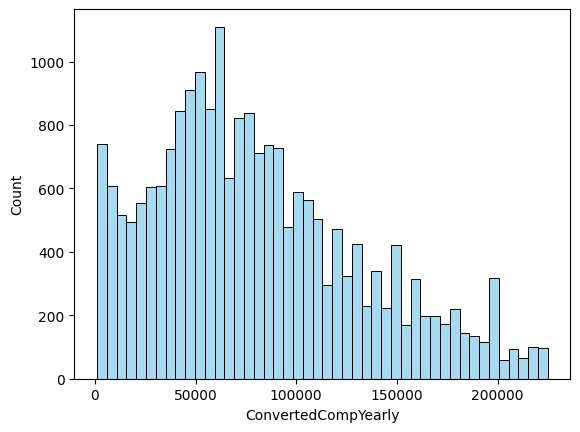

In [ ]:
sns.histplot(df['ConvertedCompYearly'],kde=False, color='skyblue', edgecolor='black')
plt.show()

Box plot analysis of salaries with respect to top countries and according to the graph USA has high median salaries

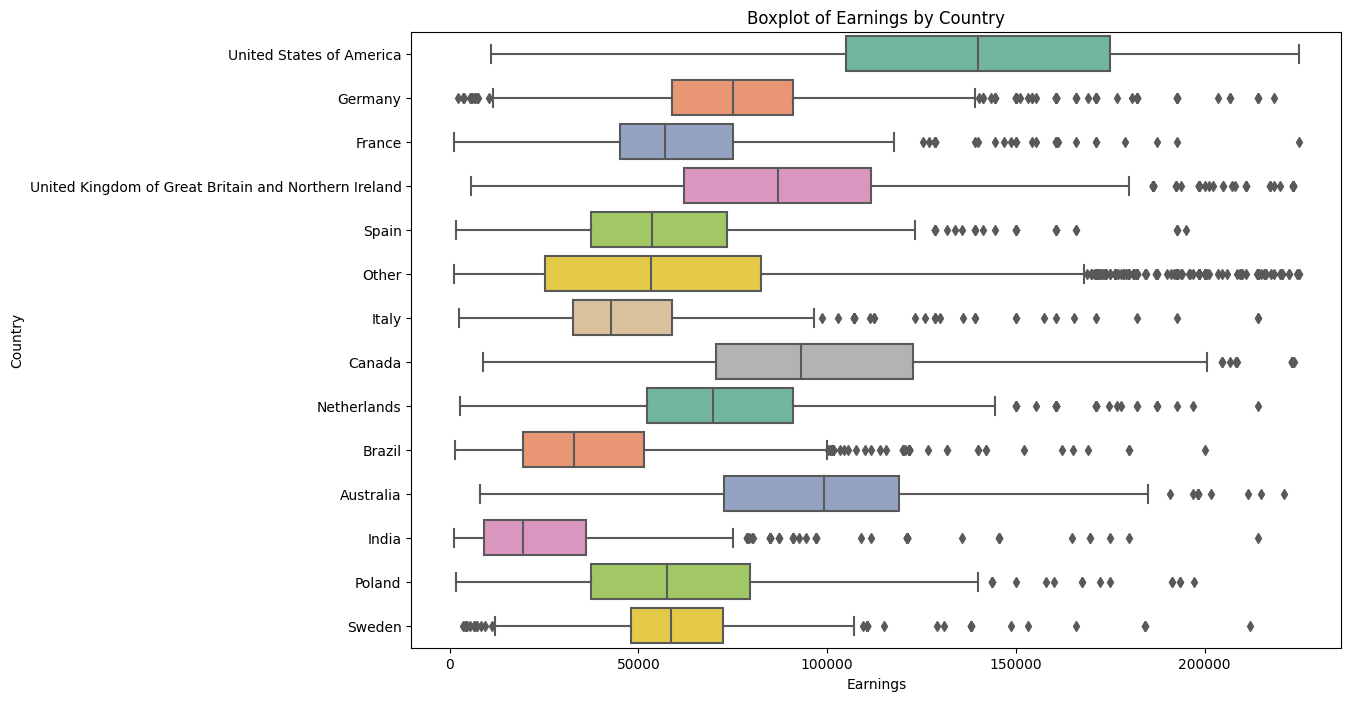

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(y='Country', x='ConvertedCompYearly', data=df, palette='Set2')

plt.ylabel('Country')
plt.xlabel('Earnings')
plt.title('Boxplot of Earnings by Country')

plt.show()

Below is histogram of years of coding exprience and according to which range 10 years of coding exprience has alot frefuency

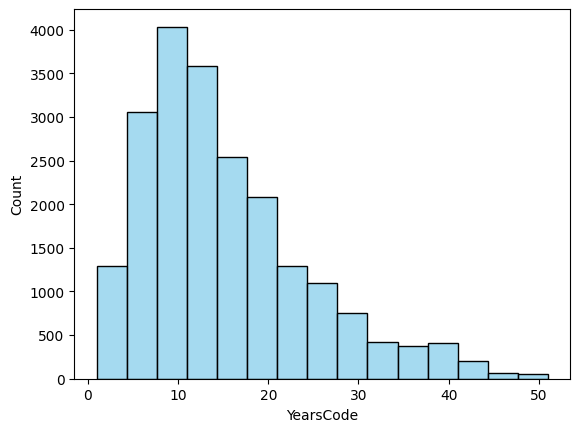

In [ ]:
sns.histplot(df['YearsCode'],kde=False,bins=15, color='skyblue', edgecolor='black')
plt.show()

Below graph is a boxplot about range of years of coding exprience with earnings and from graph we can see that the median of young age groups to old age groups is gradually rising . Age group 30+ years of exprience has highest 5 number summaries

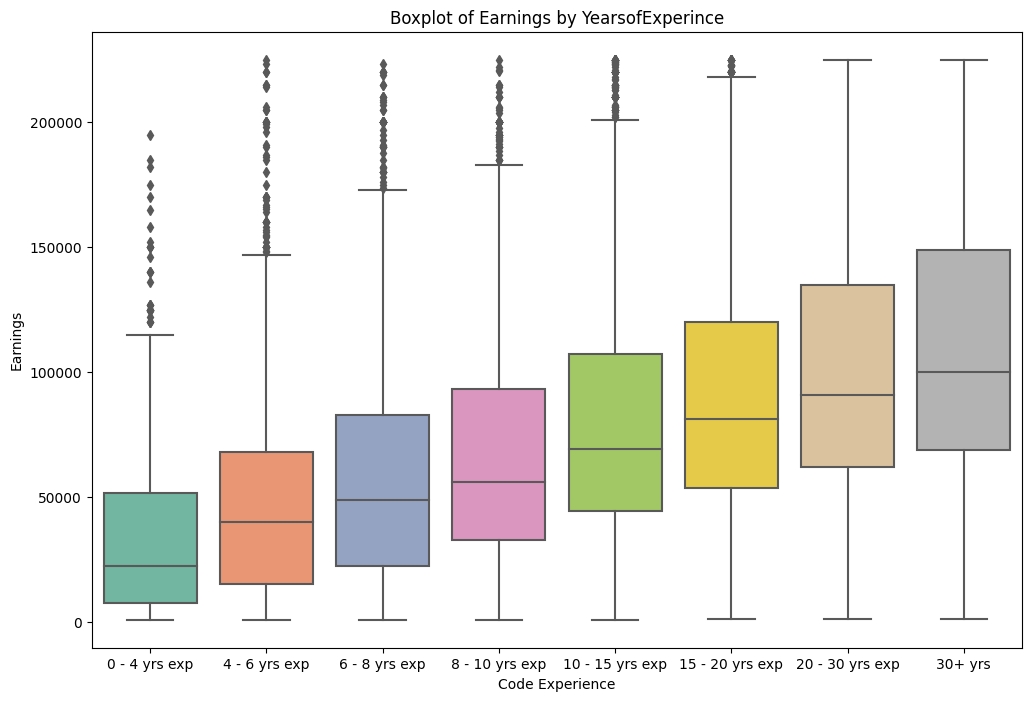

In [ ]:
plt.figure(figsize=(12, 8))
order = ['0 - 4 yrs exp',
         '4 - 6 yrs exp',
        '6 - 8 yrs exp',
        '8 - 10 yrs exp',
        '10 - 15 yrs exp',
        '15 - 20 yrs exp',
        '20 - 30 yrs exp',
        '30+ yrs'
        ]
sns.boxplot(x='CodeExp', y='ConvertedCompYearly', data=df, palette='Set2', order = order)

plt.xlabel('Code Experience')
plt.ylabel('Earnings')
plt.title('Boxplot of Earnings by YearsofExperince')

# Show the plot
plt.show()

Below graph is the pie chart that describes the value count of each and every age group and displays the percentage according to the graph 25 to 34 age group has the highest pie followed by 35to 44 age group

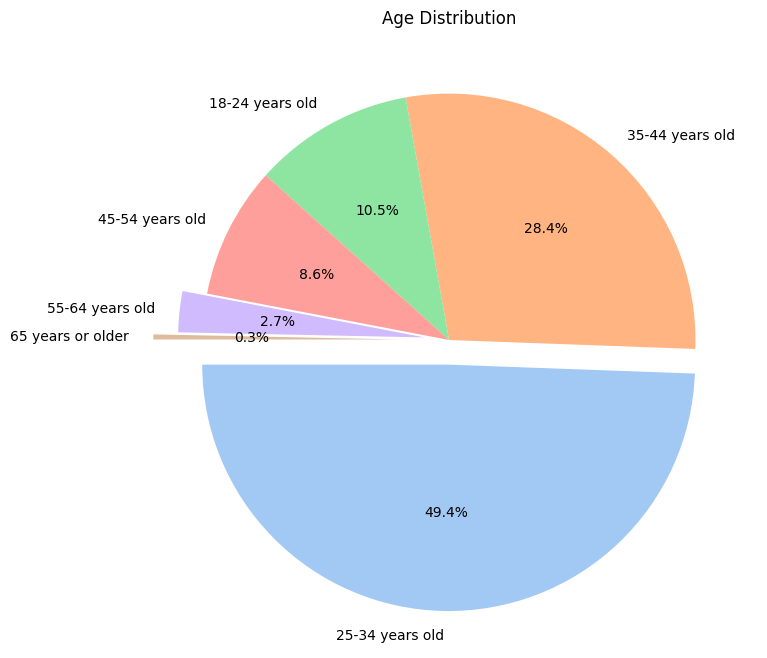

In [ ]:
df = df[df['Age']!= 'Prefer not to say']
df = df[df['Age']!= 'Under 18 years old']
age_counts = df['Age'].value_counts()


plt.figure(figsize=(8, 8))
sns.set_palette('pastel')
explode = (0.1, 0, 0, 0, 0.1, 0.2)
plt.pie(age_counts.values, labels=age_counts.index, autopct='%1.1f%%', startangle=180, explode=explode, labeldistance=1.1)


plt.title('Age Distribution')


plt.show()

Utilized a clustermap to visualize relationships between languages worked with and desired languages. From graph we came to know that people who already worked on javascript and more intrested to work currently only on HTML / CSS

<Figure size 1200x800 with 0 Axes>

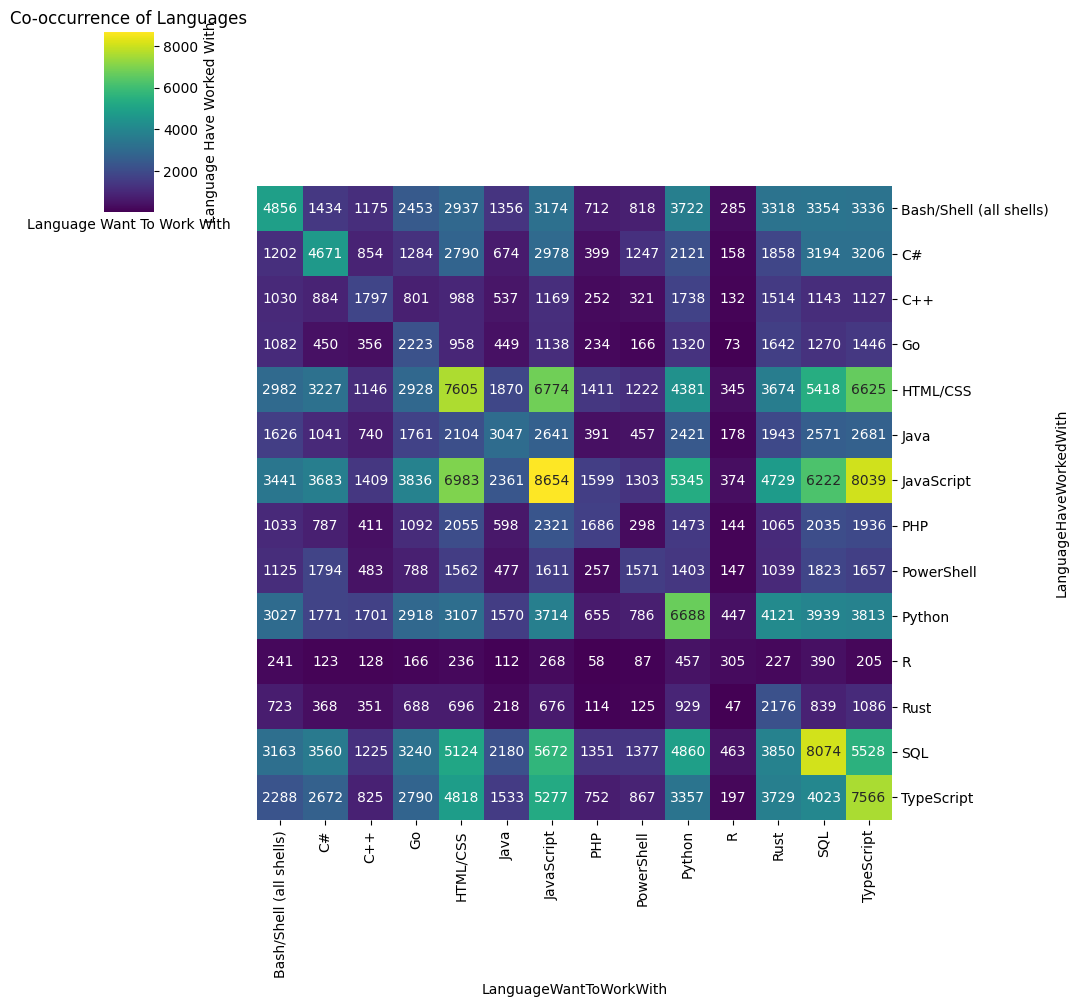

In [ ]:
df_lang = df[['LanguageHaveWorkedWith', 'LanguageWantToWorkWith']]
top_languages = ['Java', 'Python','Bash/Shell (all shells)', 'HTML/CSS','PHP',
                 'TypeScript', 'JavaScript','Rust', 'SQL', 'PowerShell', 'C#', 'R', 'Go', 'C++']

df_lang['LanguageHaveWorkedWith'] = df_lang['LanguageHaveWorkedWith'].str.split(';')
df_lang['LanguageWantToWorkWith'] = df_lang['LanguageWantToWorkWith'].str.split(';')
df_lang['WorkingLanguage'] = df_lang.apply(lambda row: set(row['LanguageHaveWorkedWith']).difference(set(row['LanguageWantToWorkWith'])), axis=1)
df_lang['DesiredLanguage'] = df_lang.apply(lambda row: set(row['LanguageWantToWorkWith']).difference(set(row['LanguageHaveWorkedWith'])), axis=1)

df_exploded = df_lang.explode('LanguageHaveWorkedWith').explode('LanguageWantToWorkWith')
df_exploded = df_exploded[df_exploded['LanguageHaveWorkedWith'].isin(top_languages)]
df_exploded = df_exploded[df_exploded['LanguageWantToWorkWith'].isin(top_languages)]

binary_matrix = pd.crosstab(df_exploded['LanguageHaveWorkedWith'], df_exploded['LanguageWantToWorkWith'], margins=False)


plt.figure(figsize=(12, 8))
sns.clustermap(binary_matrix, cmap='viridis', annot=True, fmt='d', cbar_kws={'use_gridspec': False}, row_cluster=False, col_cluster=False)


plt.xlabel('Language Want To Work With')
plt.ylabel('Language Have Worked With')
plt.title('Co-occurrence of Languages')


plt.show()

In [ ]:
count_have_worked_with = df_exploded['LanguageHaveWorkedWith'].value_counts()
count_want_to_work_with = df_exploded['LanguageWantToWorkWith'].value_counts()


print("Counts of each language in LanguageHaveWorkedWith:")
print(count_have_worked_with)

print("\nCounts of each language in LanguageWantToWorkWith:")
print(count_want_to_work_with)

Counts of each language in LanguageHaveWorkedWith:
JavaScript                 57978
SQL                        49667
HTML/CSS                   49608
TypeScript                 40694
Python                     38257
Bash/Shell (all shells)    32930
C#                         26636
Java                       23602
PHP                        16934
PowerShell                 15737
C++                        13433
Go                         12807
Rust                        9036
R                           3003
Name: LanguageHaveWorkedWith, dtype: int64

Counts of each language in LanguageWantToWorkWith:
TypeScript                 48251
JavaScript                 46067
SQL                        44295
HTML/CSS                   41963
Python                     40215
Rust                       34885
Bash/Shell (all shells)    27819
Go                         26968
C#                         26465
Java                       16982
C++                        12601
PowerShell                 10

In [ ]:
dev_list = ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
       'Developer, desktop or enterprise applications', 'Developer, mobile','DevOps specialist',
       'Data scientist or machine learning specialist', 'Engineer, data','Cloud infrastructure engineer', 'Developer, QA or test']
df['DevType'].value_counts()

Developer, full-stack                            7662
Developer, back-end                              4687
Developer, front-end                             1464
Developer, desktop or enterprise applications    1039
Developer, mobile                                 774
Engineering manager                               584
Other (please specify):                           562
Developer, embedded applications or devices       527
DevOps specialist                                 468
Data scientist or machine learning specialist     413
Engineer, data                                    388
Cloud infrastructure engineer                     341
Research & Development role                       334
Senior Executive (C-Suite, VP, etc.)              328
Academic researcher                               237
Developer, QA or test                             172
Developer, game or graphics                       161
Engineer, site reliability                        152
Data or business analyst    

Below is the box plot for earning according to various developer types (like full stack, backend , front end etc).According to the graph cloud infrastructure and services engineers earn more compaired to everyone and also having maximum range

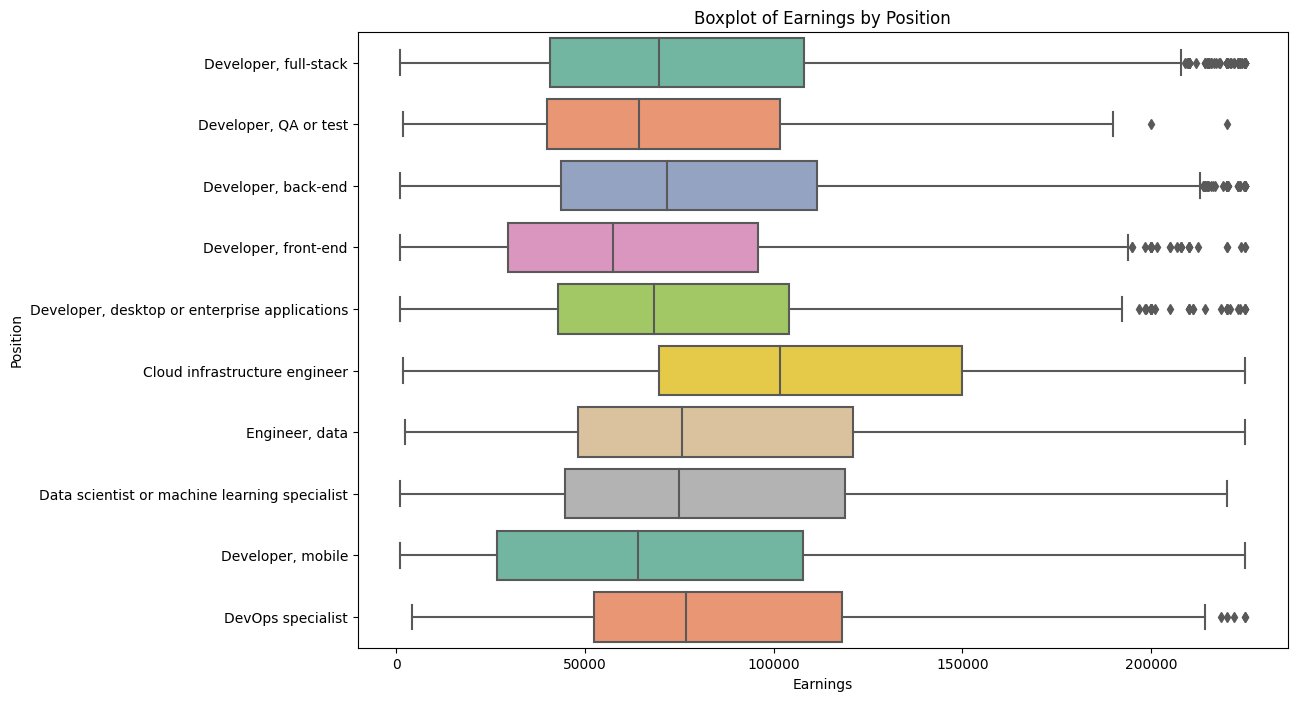

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(y='DevType', x='ConvertedCompYearly', data=df[df['DevType'].isin(dev_list)], palette='Set2')

plt.ylabel('Position')

plt.xlabel('Earnings')

plt.title('Boxplot of Earnings by Position')


plt.show()


In [ ]:
df[df['DevType'].isin(dev_list)].groupby('DevType')['ConvertedCompYearly'].describe()

,count,mean,std,min,25%,50%,75%,max
DevType,,,,,,,,
Cloud infrastructure engineer,341.0,110563.070381,56411.191610,1717.0,69608.00,101735.0,150000.00,225000.0
Data scientist or machine learning specialist,413.0,84030.903148,52989.935579,1070.0,44633.00,74963.0,118987.00,220000.0
DevOps specialist,468.0,86809.228632,50322.794121,4284.0,52474.00,76868.5,118188.75,225000.0
"Developer, QA or test",172.0,73660.476744,49094.128077,1750.0,39931.00,64254.0,101735.00,220000.0
"Developer, back-end",4687.0,81270.245786,51554.197835,1000.0,43645.50,71779.0,111527.00,225000.0
"Developer, desktop or enterprise applications",1039.0,77847.207892,48683.548648,1030.0,42836.00,68240.0,104092.00,225000.0
"Developer, front-end",1464.0,67320.135246,49362.949147,1144.0,29705.50,57487.5,95778.75,225000.0
"Developer, full-stack",7662.0,78292.561081,50798.696389,1000.0,40807.00,69608.0,108000.00,225000.0
"Developer, mobile",774.0,72900.645995,54113.415975,1000.0,26685.75,64105.0,107772.50,225000.0


In [ ]:
df['Industry'].value_counts()

Information Services, IT, Software Development, or other Technology    11540
Financial Services                                                      2892
Manufacturing, Transportation, or Supply Chain                          1783
Healthcare                                                              1466
Retail and Consumer Services                                            1346
Higher Education                                                         777
Advertising Services                                                     509
Insurance                                                                506
Oil & Gas                                                                182
Legal Services                                                           148
Wholesale                                                                109
Name: Industry, dtype: int64

In [ ]:
df['EdLevel'].value_counts()

Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          10328
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        5878
Some college/university study without earning a degree                                 2476
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)      961
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                          877
Associate degree (A.A., A.S., etc.)                                                     738
Name: EdLevel, dtype: int64

In [ ]:
df['Eduction Level'] = df['EdLevel'].apply(get_education_details)

In [ ]:
df_median_salary = df.groupby(['Industry', 'Eduction Level'])['ConvertedCompYearly'].median().reset_index()
df_median_salary.columns = ['Industry', 'Eduction Level', 'Median Salary']
df_median_salary = df_median_salary.sort_values(by = ['Median Salary'])
df_median_salary = df_median_salary[df_median_salary['Industry']!='Other']
df_median_salary = df_median_salary[df_median_salary['Eduction Level']!='Other']

Stacked bar chart between various educational levels and various industries over salaries of people  

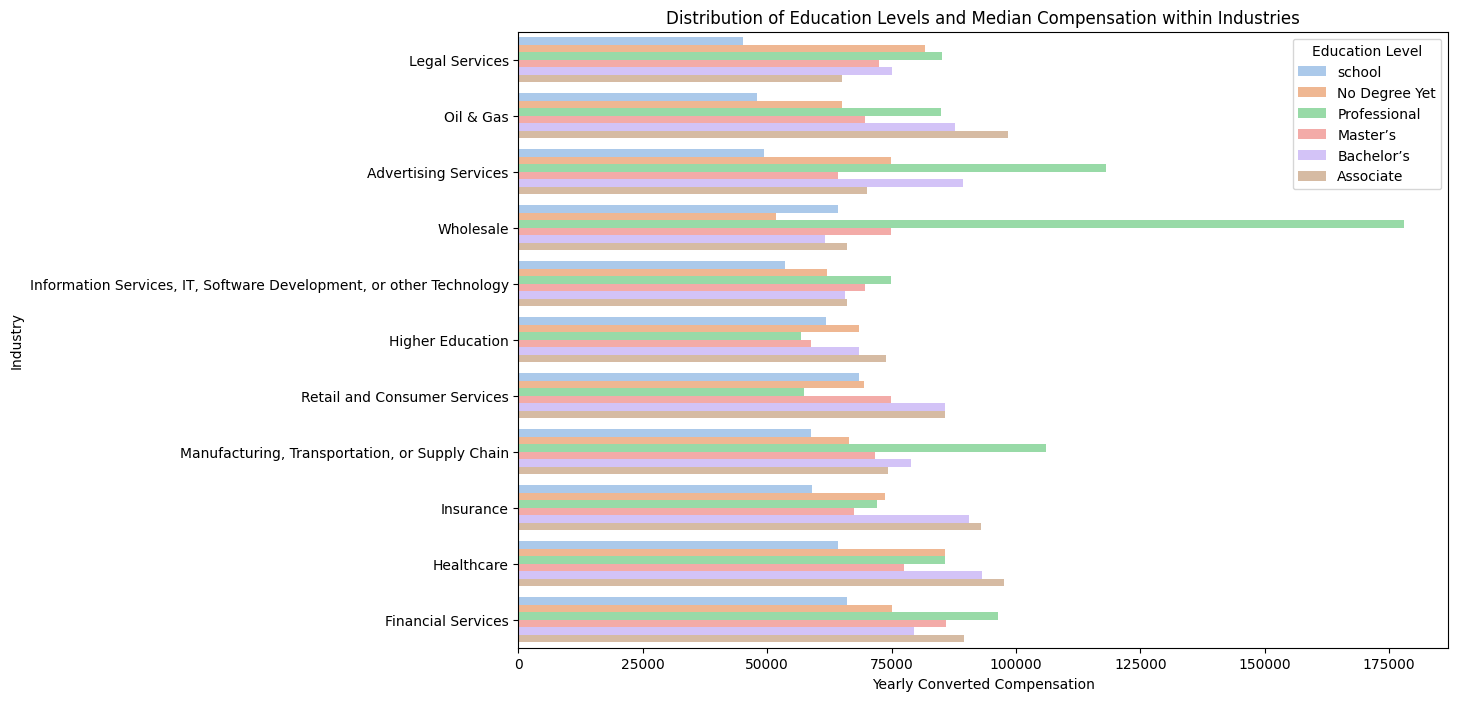

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(y='Industry', x='Median Salary', hue='Eduction Level', data=df_median_salary)


plt.ylabel('Industry')
plt.xlabel('Yearly Converted Compensation')
plt.title('Distribution of Education Levels and Median Compensation within Industries')


plt.legend(title='Education Level')


plt.show()

Box plot analysis of salaries with respect to various industries and according to the graph healthcare has high median salaries

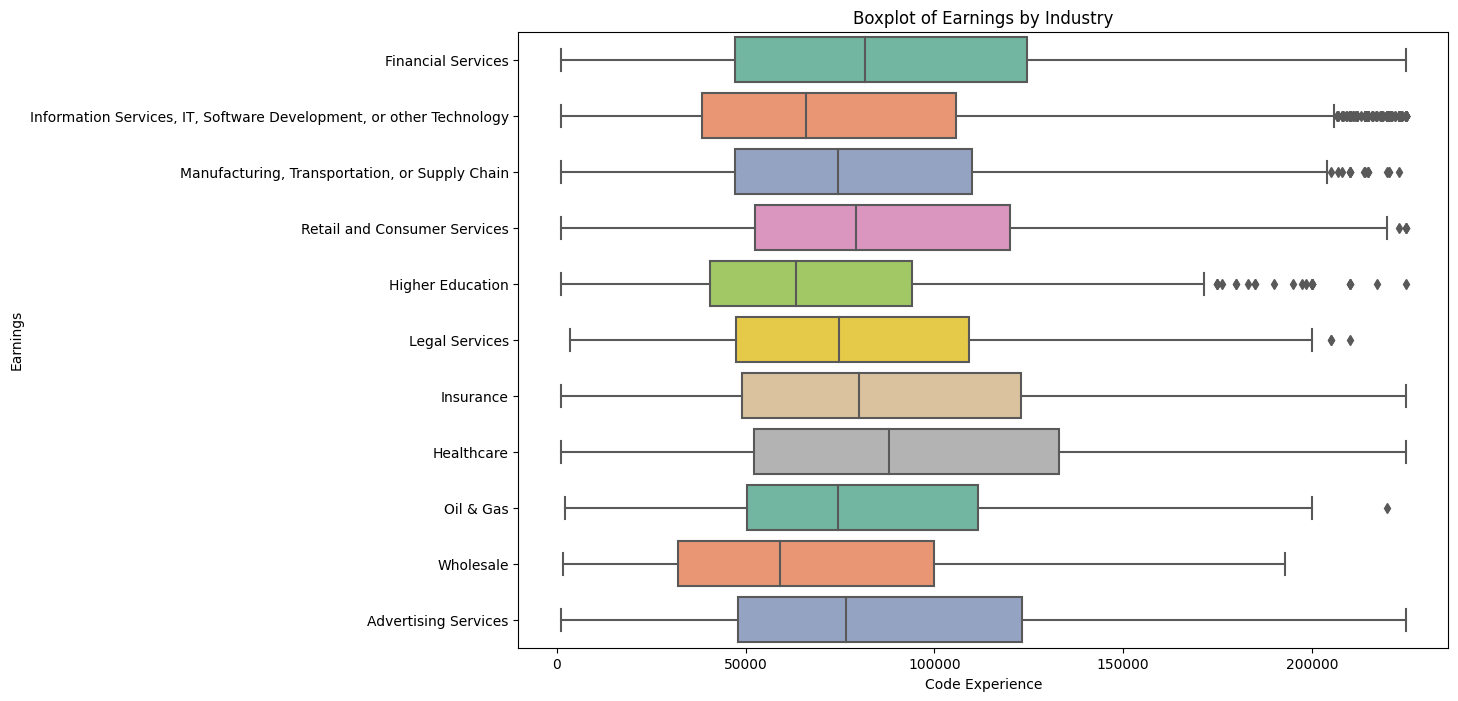

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(y='Industry', x='ConvertedCompYearly', data=df, palette='Set2')

plt.xlabel('Code Experience')
plt.ylabel('Earnings')
plt.title('Boxplot of Earnings by Industry')

plt.show()

In [ ]:
df.groupby('Industry')['ConvertedCompYearly'].median().sort_values(ascending=False)

Industry
Healthcare                                                             87906.5
Financial Services                                                     81721.0
Insurance                                                              80158.5
Retail and Consumer Services                                           79347.0
Advertising Services                                                   76564.0
Legal Services                                                         74723.0
Manufacturing, Transportation, or Supply Chain                         74483.0
Oil & Gas                                                              74417.0
Information Services, IT, Software Development, or other Technology    66036.0
Higher Education                                                       63385.0
Wholesale                                                              59056.0
Name: ConvertedCompYearly, dtype: float64

In [ ]:
df['CodingActivities'].str.split(';').explode().value_counts()

Hobby                                                                  15495
Professional development or self-paced learning from online courses     8574
Contribute to open-source projects                                      5373
Freelance/contract work                                                 3796
Bootstrapping a business                                                2981
I don’t code outside of work                                            2480
School or academic work                                                 1253
Other (please specify):                                                  342
Name: CodingActivities, dtype: int64

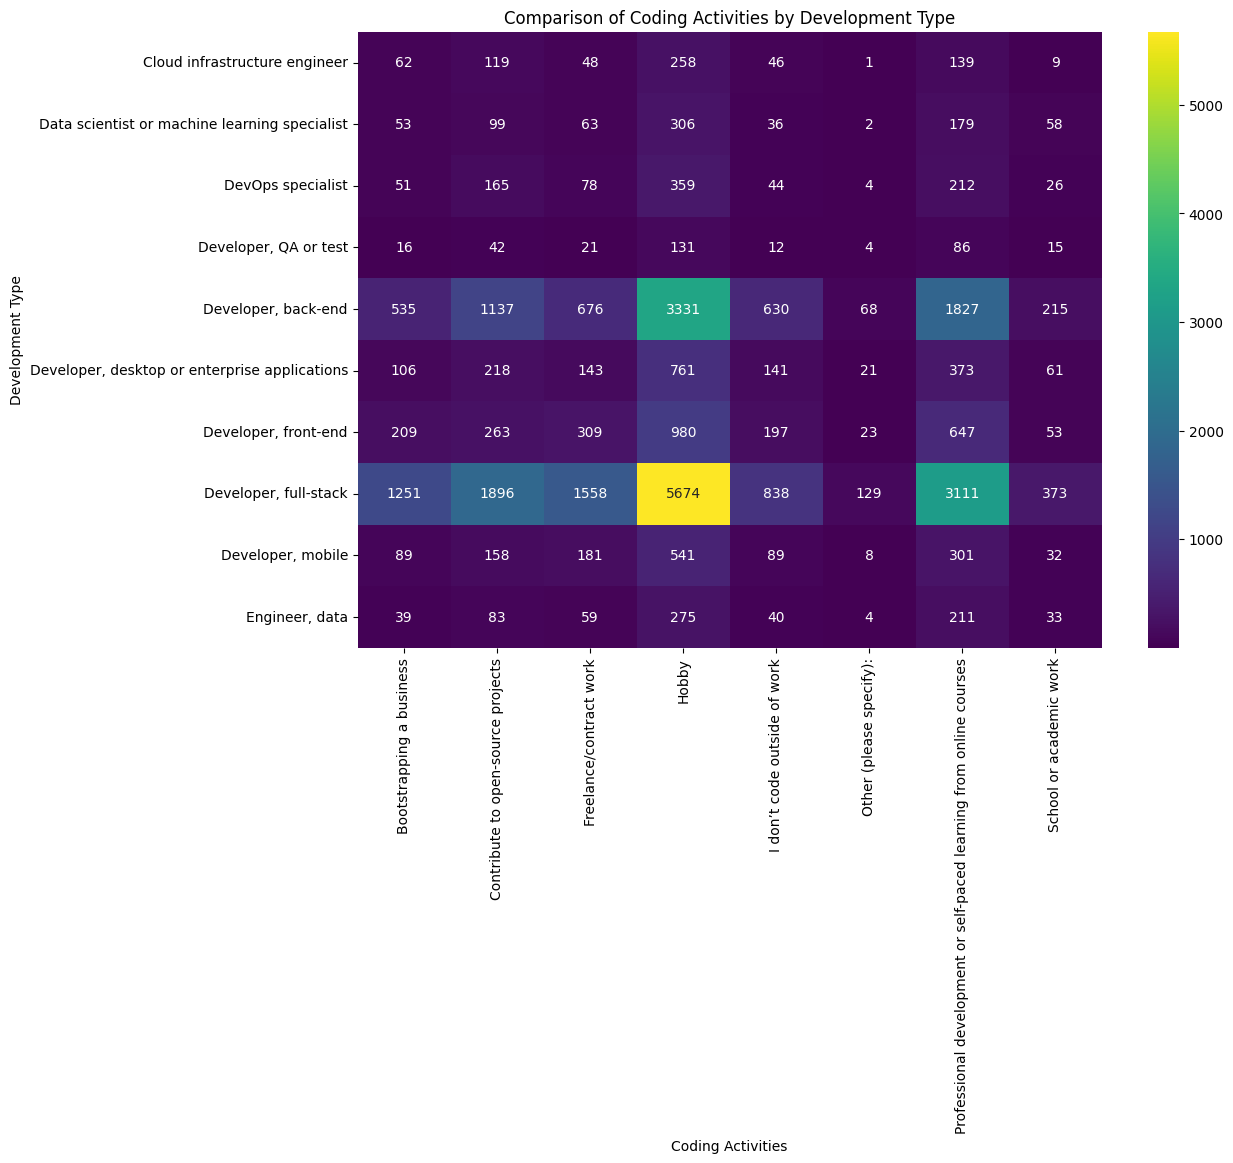

In [ ]:

df['CodingActivitiesSplit'] = df['CodingActivities'].str.split(';')
df_dev = df[df['DevType'].isin(dev_list)]

df_binary = pd.get_dummies(df_dev['CodingActivitiesSplit'].explode())


df_binary['DevType'] = df_dev['DevType'].explode()
df_binary = df_binary.groupby('DevType').sum()


plt.figure(figsize=(12, 8))
sns.heatmap(df_binary, cmap='viridis', annot=True, fmt='d', cbar=True)

plt.xlabel('Coding Activities')
plt.ylabel('Development Type')
plt.title('Comparison of Coding Activities by Development Type')


plt.show()

In [ ]:
df_emp = df[['Employment', 'WorkExp', 'ConvertedCompYearly']]
df_emp['EmpType'] = df_emp['Employment'].apply(get_employement)
df_emp = df_emp[df_emp['EmpType']!=-1]
df_emp['ExpYrs'] = df_emp['WorkExp'].apply(partition_workexp)
df_emp.head()

,Employment,WorkExp,ConvertedCompYearly,EmpType,ExpYrs
7,"Employed, full-time",5.0,80000.0,Full Time,1 - 10 yrs exp
13,"Employed, full-time",10.0,150000.0,Full Time,10 - 20 yrs exp
15,"Employed, full-time",15.0,107090.0,Full Time,10 - 20 yrs exp
17,"Employed, full-time",6.0,58899.0,Full Time,1 - 10 yrs exp
19,"Employed, full-time",14.0,75010.0,Full Time,10 - 20 yrs exp


In [ ]:
median_salary_by_emp = df_emp.groupby(['EmpType','ExpYrs'])['ConvertedCompYearly'].median().reset_index()
median_salary_by_emp.columns = ['EmpType', 'ExpYrs', 'Median Salary']

# Merge the median salary information back to the original DataFrame
df_emp_new = pd.merge(df_emp, median_salary_by_emp, on=['EmpType', 'ExpYrs'], how='left')
df_emp_new.head()

,Employment,WorkExp,ConvertedCompYearly,EmpType,ExpYrs,Median Salary
0,"Employed, full-time",5.0,80000.0,Full Time,1 - 10 yrs exp,55764.0
1,"Employed, full-time",10.0,150000.0,Full Time,10 - 20 yrs exp,85672.0
2,"Employed, full-time",15.0,107090.0,Full Time,10 - 20 yrs exp,85672.0
3,"Employed, full-time",6.0,58899.0,Full Time,1 - 10 yrs exp,55764.0
4,"Employed, full-time",14.0,75010.0,Full Time,10 - 20 yrs exp,85672.0


below is the Scatter Plot of Employment and Years of Experience (Color-coded by Median Compensation)

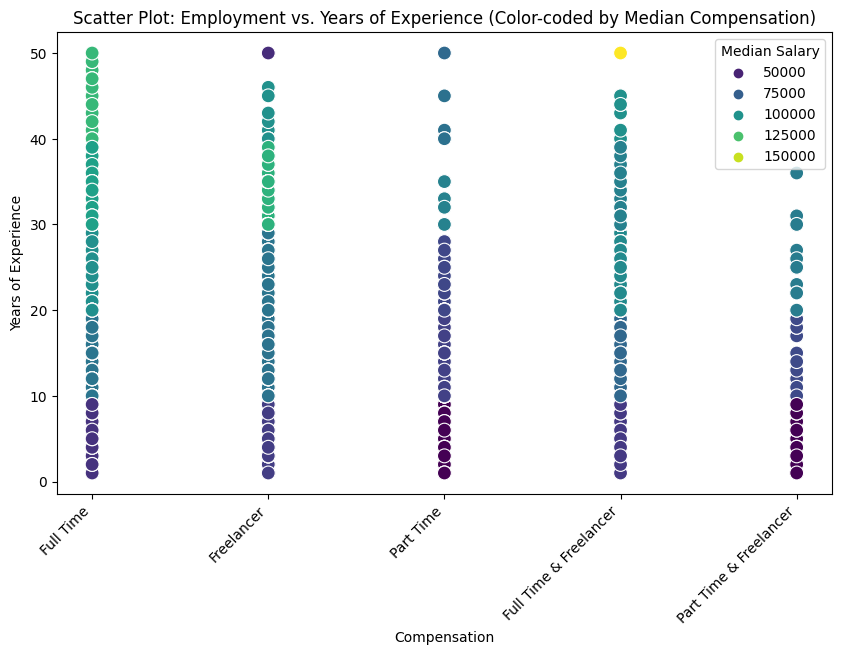

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EmpType', y='WorkExp', hue='Median Salary', palette='viridis', data=df_emp_new, s=100)


plt.xlabel('Compensation')
plt.ylabel('Years of Experience')
plt.title('Scatter Plot: Employment vs. Years of Experience (Color-coded by Median Compensation)')



plt.xticks(rotation=45, ha='right')

plt.show()

In [ ]:
df_hobby = df[['CodingActivities', 'ConvertedCompYearly']]

The below graph is about involvement in hobby related activities and comparision with median salaries . People who are engaged in hobby related activites are having higher median

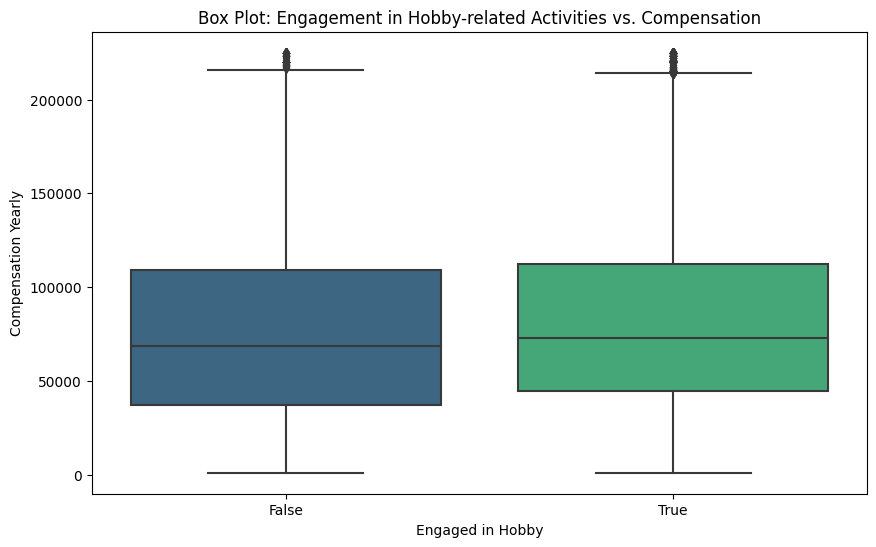

In [ ]:
df_hobby['Engaged in Hobby'] = df_hobby['CodingActivities'].apply(lambda x: 'Hobby' in x.split(';'))


plt.figure(figsize=(10, 6))
sns.boxplot(x='Engaged in Hobby', y='ConvertedCompYearly', data=df_hobby, palette='viridis')


plt.xlabel('Engaged in Hobby')
plt.ylabel('Compensation Yearly')
plt.title('Box Plot: Engagement in Hobby-related Activities vs. Compensation')


plt.show()

<Figure size 1200x800 with 0 Axes>

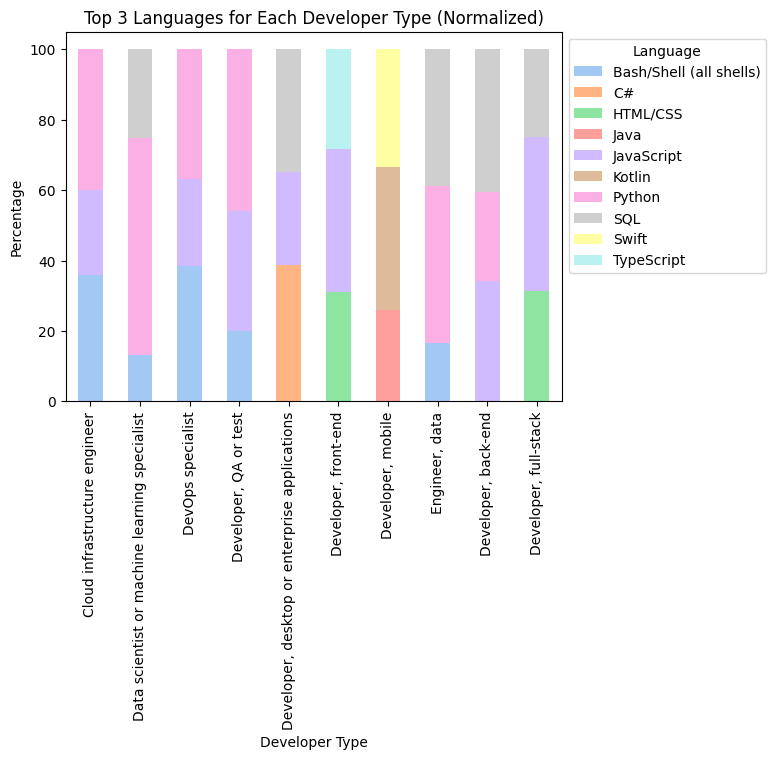

In [ ]:
dev_list = ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
       'Developer, desktop or enterprise applications', 'Developer, mobile','DevOps specialist',
       'Data scientist or machine learning specialist', 'Engineer, data','Cloud infrastructure engineer', 'Developer, QA or test']

df_dev = df[df['DevType'].isin(dev_list)]

df_dev['LanguageHaveWorkedWith'] = df_dev['LanguageHaveWorkedWith'].str.split(';')

df_exploded = df_dev.explode('LanguageHaveWorkedWith')


df_exploded['Count'] = df_exploded.groupby(['DevType', 'LanguageHaveWorkedWith']).transform('size')


top_languages_by_dev_type = df_exploded.groupby(['DevType', 'LanguageHaveWorkedWith'])['Count'].sum().reset_index()
top_languages_by_dev_type = top_languages_by_dev_type.groupby('DevType').apply(lambda x: x.nlargest(3, 'Count')).reset_index(drop=True)


top_languages_by_dev_type['Count'] = top_languages_by_dev_type.groupby('DevType')['Count'].transform(lambda x: (x / x.sum()) * 100)


language_counts_pivot = top_languages_by_dev_type.pivot(index='DevType', columns='LanguageHaveWorkedWith', values='Count').fillna(0)


language_counts_pivot = language_counts_pivot.reindex(language_counts_pivot.sum(axis=1).sort_values(ascending=False).index)


plt.figure(figsize=(12, 8))
language_counts_pivot.plot(kind='bar', stacked=True)


plt.xlabel('Developer Type')
plt.ylabel('Percentage')
plt.title('Top 3 Languages for Each Developer Type (Normalized)')


plt.legend(title='Language', bbox_to_anchor=(1, 1))
plt.show()

<Figure size 1200x800 with 0 Axes>

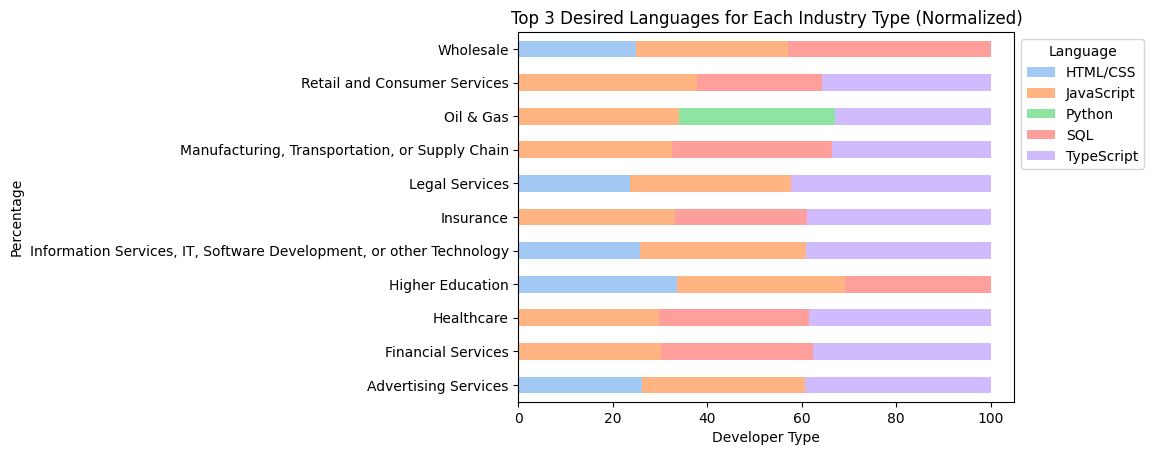

In [ ]:
dev_list = ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
       'Developer, desktop or enterprise applications', 'Developer, mobile','DevOps specialist',
       'Data scientist or machine learning specialist', 'Engineer, data','Cloud infrastructure engineer', 'Developer, QA or test']

df_dev = df[df['DevType'].isin(dev_list)]

df_dev['LanguageWantToWorkWith'] = df_dev['LanguageWantToWorkWith'].str.split(';')

df_exploded = df_dev.explode('LanguageWantToWorkWith')


df_exploded['Count'] = df_exploded.groupby(['Industry', 'LanguageWantToWorkWith']).transform('size')


top_languages_by_dev_type = df_exploded.groupby(['Industry', 'LanguageWantToWorkWith'])['Count'].sum().reset_index()
top_languages_by_dev_type = top_languages_by_dev_type.groupby('Industry').apply(lambda x: x.nlargest(3, 'Count')).reset_index(drop=True)


top_languages_by_dev_type['Count'] = top_languages_by_dev_type.groupby('Industry')['Count'].transform(lambda x: (x / x.sum()) * 100)


language_counts_pivot = top_languages_by_dev_type.pivot(index='Industry', columns='LanguageWantToWorkWith', values='Count').fillna(0)


language_counts_pivot = language_counts_pivot.reindex(language_counts_pivot.sum(axis=1).sort_values(ascending=False).index)


plt.figure(figsize=(12, 8))
language_counts_pivot.plot(kind='barh', stacked=True)


plt.xlabel('Developer Type')
plt.ylabel('Percentage')
plt.title('Top 3 Desired Languages for Each Industry Type (Normalized)')


plt.legend(title='Language', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
df_lang = df[['LanguageWantToWorkWith', 'WorkExp']]
df_lang['NumLanguages'] = df_lang['LanguageWantToWorkWith'].str.split(";").apply(len)
df_lang['YrsGrp'] = df_lang['WorkExp'].apply(get_exp_group)
df_lang.head()

,LanguageWantToWorkWith,WorkExp,NumLanguages,YrsGrp
7,Elixir;Go;Julia;Python;R;Rust;Scala;SQL;TypeSc...,5.0,10,10-20 yrs
13,Assembly;C;C++;Go;Python;Rust,10.0,6,10-20 yrs
15,Bash/Shell (all shells);Dart;Go;HTML/CSS;Java;...,15.0,10,10-20 yrs
17,Go;HTML/CSS;JavaScript;Rust;SQL;TypeScript,6.0,6,10-20 yrs
19,JavaScript;TypeScript,14.0,2,10-20 yrs


In [ ]:
group_correlations = df_lang.groupby('YrsGrp').apply(lambda group: group['WorkExp'].corr(group['NumLanguages'])).reset_index()
group_correlations.columns = ['YrsGrp', 'Correlation']


print(group_correlations)

      YrsGrp  Correlation
0  10-20 yrs    -0.044689
1  20-30 yrs     0.024628
2  30-40 yrs     0.019476
3  40-50 yrs     0.049267
4  50-60 yrs          NaN


Below is the graph for correlation analysis between number of years of work exprience and number of languages in various years groups . Correlation is negative for 10 to 20 age group and kept increasing as the age groups increase

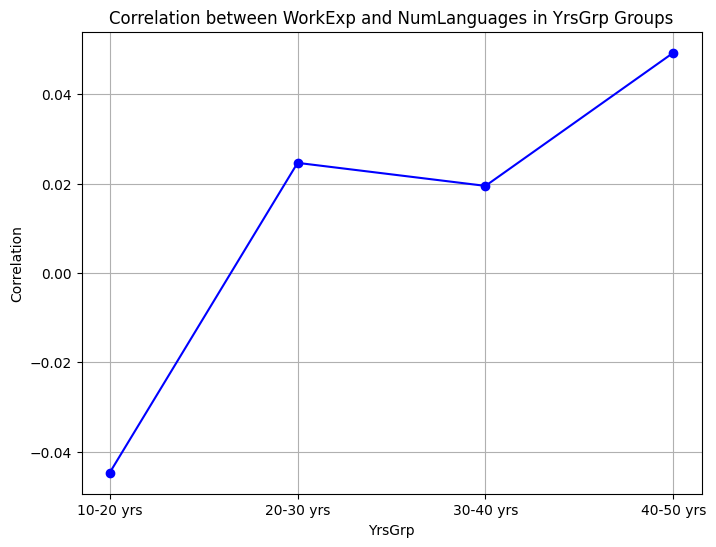

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(group_correlations['YrsGrp'], group_correlations['Correlation'], marker='o', linestyle='-', color='b')


plt.xlabel('YrsGrp')
plt.ylabel('Correlation')
plt.title('Correlation between WorkExp and NumLanguages in YrsGrp Groups')


plt.grid(True)
plt.show()

The graph is about number of years of average work exprience of people having various education levels across various different countries.

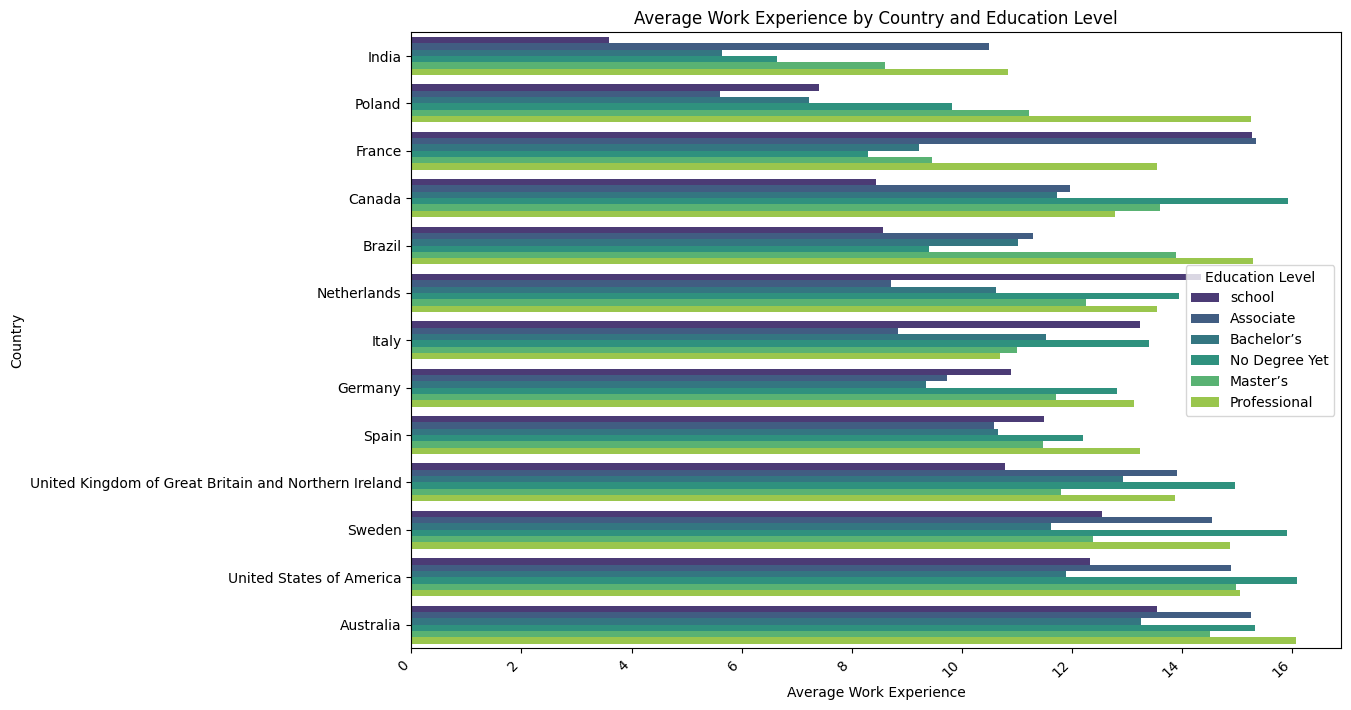

In [ ]:
df_edu = df[['Country', 'EdLevel','WorkExp']]
df_edu['Education Level'] = df_edu['EdLevel'].apply(get_education_details)
df_edu = df_edu[df_edu['Country']!='Other']
df_edu = df_edu[df_edu['Education Level']!='Other']
grouped_data = df_edu.groupby(['Country', 'Education Level'])['WorkExp'].mean().sort_values().reset_index()


plt.figure(figsize=(12, 8))
sns.barplot(y='Country', x='WorkExp', hue='Education Level', data=grouped_data, palette='viridis')

plt.ylabel('Country')
plt.xlabel('Average Work Experience')
plt.title('Average Work Experience by Country and Education Level')


plt.xticks(rotation=45, ha='right')


plt.show()

In [ ]:
df_open_source = df[['CodingActivities', 'ConvertedCompYearly']]

In [ ]:
set(df_open_source['CodingActivities'].str.split(";").explode())

{'Bootstrapping a business',
 'Contribute to open-source projects',
 'Freelance/contract work',
 'Hobby',
 'I don’t code outside of work',
 'Other (please specify):',
 'Professional development or self-paced learning from online courses',
 'School or academic work'}

Below is the box plot that describes yes or No about Open source contribution vs salaries . People who have open source contribution have higher median saalaries

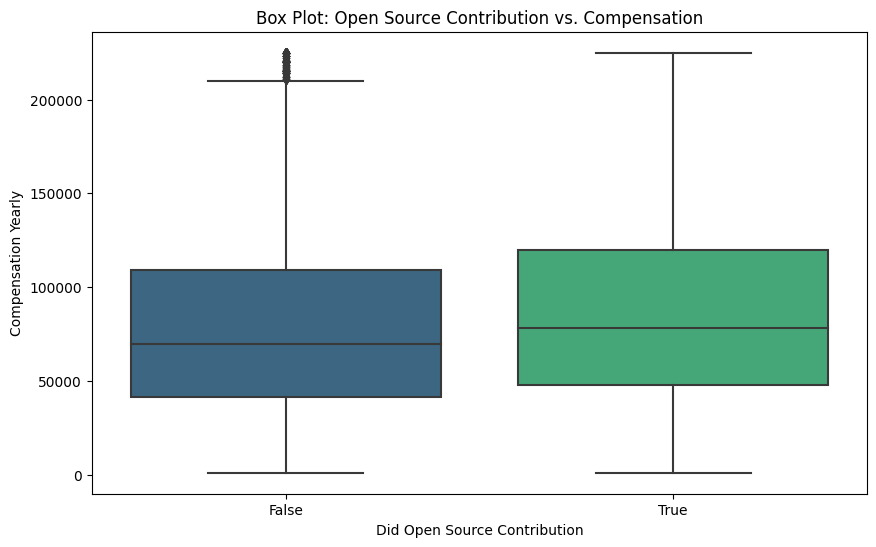

In [ ]:
df_open_source['OpenSourceContrib'] = df_open_source['CodingActivities'].apply(lambda x: 'open-source' in str(x))


plt.figure(figsize=(10, 6))
sns.boxplot(x='OpenSourceContrib', y='ConvertedCompYearly', data=df_open_source, palette='viridis')


plt.xlabel('Did Open Source Contribution')
plt.ylabel('Compensation Yearly')
plt.title('Box Plot: Open Source Contribution vs. Compensation')

plt.show()

<Figure size 1200x800 with 0 Axes>

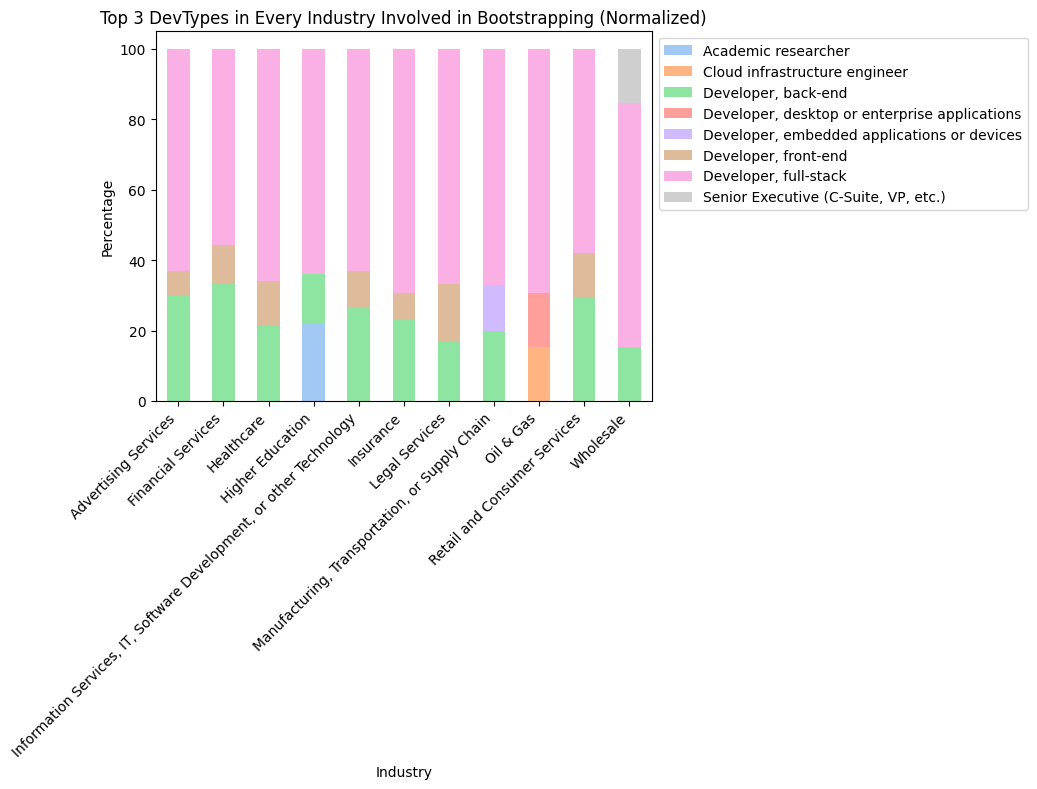

In [ ]:
df_bootstraping = df[['CodingActivities', 'Industry', 'DevType']]
df_bootstraping = df[df['CodingActivities'].str.contains('Bootstrapping')]


top3_devtypes = df_bootstraping.groupby(['Industry', 'DevType']).size().groupby('Industry').nlargest(3).reset_index(level=0, drop=True).reset_index(name='Count')


pivot_df = top3_devtypes.pivot(index='Industry', columns='DevType', values='Count').fillna(0)

pivot_df_normalized = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100


plt.figure(figsize=(12, 8))
ax = pivot_df_normalized.plot(kind='bar', stacked=True)

plt.xlabel('Industry')
plt.ylabel('Percentage')
plt.title('Top 3 DevTypes in Every Industry Involved in Bootstrapping (Normalized)')

plt.xticks(rotation=45, ha='right')


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

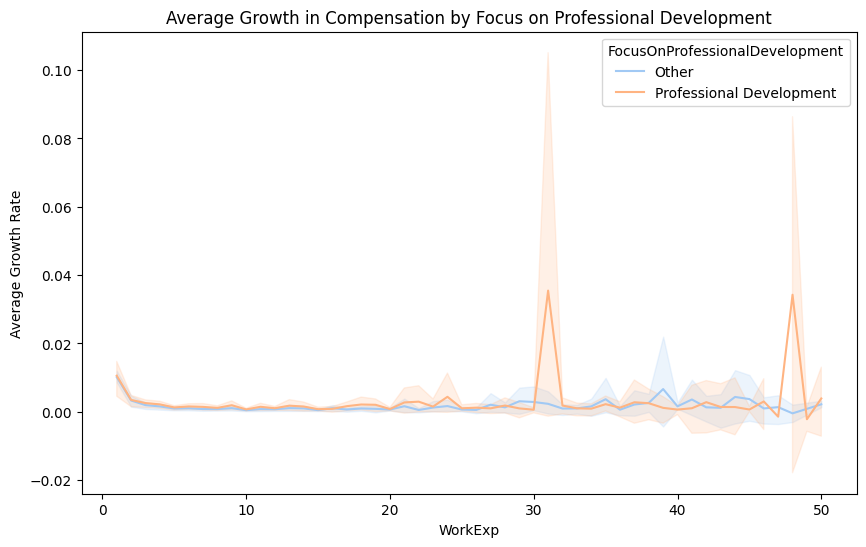

In [ ]:
df_prof = df[['CodingActivities', 'ConvertedCompYearly', 'WorkExp']]
df_prof['YrsGrp'] = df_prof['WorkExp'].apply(get_exp_group)
df_prof['FocusOnProfessionalDevelopment'] = df_prof['CodingActivities'].apply(lambda x: 'Professional Development' if 'Professional development or self-paced learning from online courses' in x else 'Other')
df_prof = df_prof.sort_values(by = ['FocusOnProfessionalDevelopment','WorkExp','ConvertedCompYearly'])

df_prof['GrowthRate'] = df_prof.groupby('YrsGrp')['ConvertedCompYearly'].pct_change() / df_prof['WorkExp']


plt.figure(figsize=(10, 6))
sns.lineplot(x='WorkExp', y='GrowthRate',hue = 'FocusOnProfessionalDevelopment' ,data=df_prof)
plt.title('Average Growth in Compensation by Focus on Professional Development')
plt.ylabel('Average Growth Rate')
plt.show()

In [ ]:
freelancer_df = df[['Employment', 'Industry', 'LanguageHaveWorkedWith']]
freelancer_df = freelancer_df[freelancer_df['Employment'].str.contains('freelancer')]

In [ ]:
freelancer_df['Industry'].value_counts()

Information Services, IT, Software Development, or other Technology    1608
Financial Services                                                      341
Retail and Consumer Services                                            179
Manufacturing, Transportation, or Supply Chain                          179
Healthcare                                                              176
Higher Education                                                         82
Advertising Services                                                     76
Insurance                                                                49
Oil & Gas                                                                18
Legal Services                                                           15
Wholesale                                                                14
Name: Industry, dtype: int64

<Figure size 1200x800 with 0 Axes>

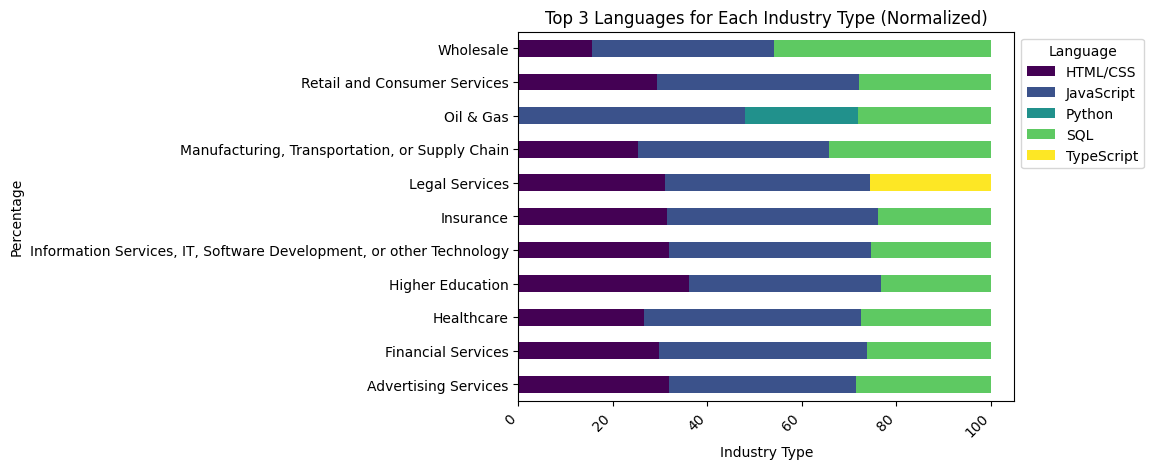

In [ ]:
freelancer_df = df[['Employment', 'Industry', 'LanguageHaveWorkedWith']]
freelancer_df = freelancer_df[freelancer_df['Employment'].str.contains('freelancer')]
freelancer_df['LanguageHaveWorkedWith'] = freelancer_df['LanguageHaveWorkedWith'].str.split(';')

df_exploded = freelancer_df.explode('LanguageHaveWorkedWith')


df_exploded['Count'] = df_exploded.groupby(['Industry', 'LanguageHaveWorkedWith']).transform('size')


top_languages_by_dev_type = df_exploded.groupby(['Industry', 'LanguageHaveWorkedWith'])['Count'].sum().reset_index()
top_languages_by_dev_type = top_languages_by_dev_type.groupby('Industry').apply(lambda x: x.nlargest(3, 'Count')).reset_index(drop=True)


top_languages_by_dev_type['Count'] = top_languages_by_dev_type.groupby('Industry')['Count'].transform(lambda x: (x / x.sum()) * 100)


language_counts_pivot = top_languages_by_dev_type.pivot(index='Industry', columns='LanguageHaveWorkedWith', values='Count').fillna(0)


language_counts_pivot = language_counts_pivot.reindex(language_counts_pivot.sum(axis=1).sort_values(ascending=False).index)


plt.figure(figsize=(12, 8))
language_counts_pivot.plot(kind='barh', stacked=True, cmap='viridis')


plt.xlabel('Industry Type')
plt.ylabel('Percentage')
plt.title('Top 3 Languages for Each Industry Type (Normalized)')

plt.xticks(rotation=45, ha='right')


plt.legend(title='Language', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
dev_list = ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
       'Developer, desktop or enterprise applications', 'Developer, mobile','DevOps specialist',
       'Data scientist or machine learning specialist', 'Engineer, data','Cloud infrastructure engineer', 'Developer, QA or test']


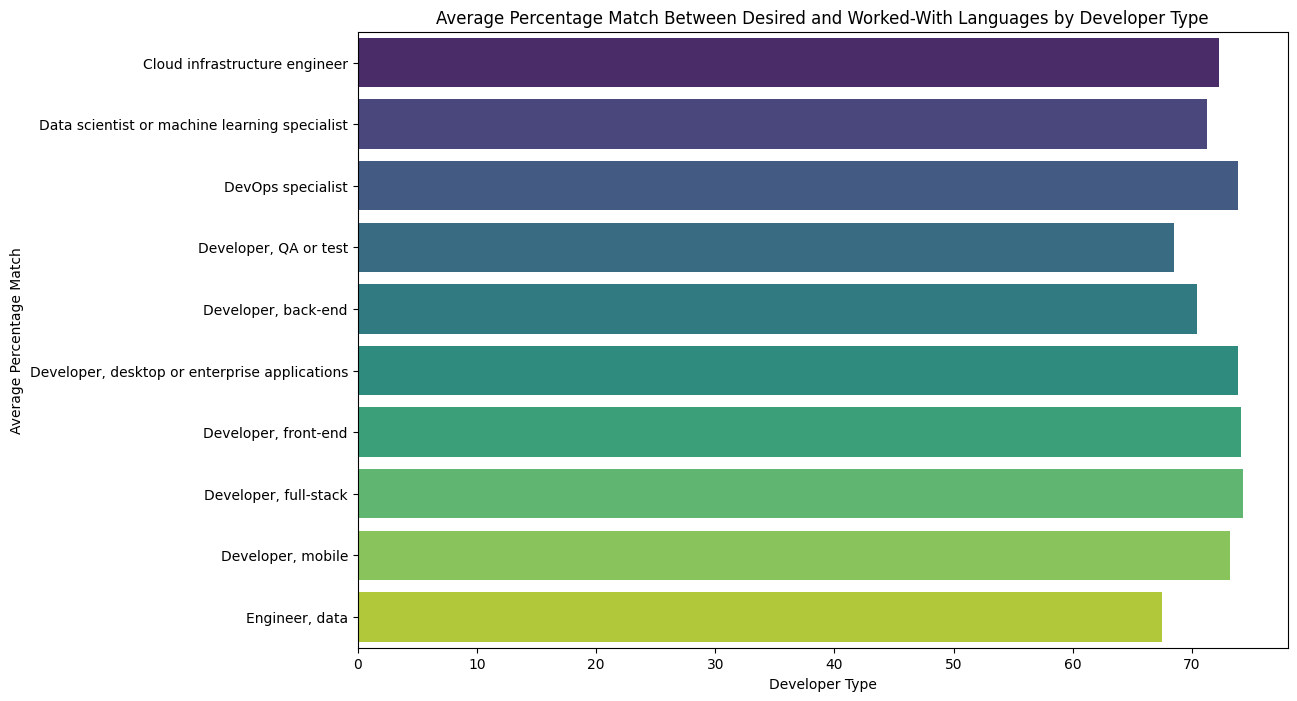

In [ ]:
df_dev = df[['DevType', 'Industry', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith']]
df_dev = df_dev[df_dev['DevType'].isin(dev_list)]
df_dev['LanguageHaveWorkedWith'] = df_dev['LanguageHaveWorkedWith'].apply(lambda x: x.split(';'))
df_dev['LanguageWantToWorkWith'] = df_dev['LanguageWantToWorkWith'].apply(lambda x: x.split(';'))


df_dev['PercentageMatch'] = df_dev.apply(lambda row: len(set(row['LanguageWantToWorkWith']).intersection(row['LanguageHaveWorkedWith'])) / len(row['LanguageWantToWorkWith']) * 100, axis=1)


avg_percentage_by_dev_type = df_dev.groupby('DevType')['PercentageMatch'].mean().reset_index()


plt.figure(figsize=(12, 8))
sns.barplot(y='DevType', x='PercentageMatch', data=avg_percentage_by_dev_type, palette='viridis')
plt.title('Average Percentage Match Between Desired and Worked-With Languages by Developer Type')
plt.xlabel('Developer Type')
plt.ylabel('Average Percentage Match')
plt.show()

In [ ]:
df_dev['LangGap'] = df_dev.apply(lambda row: list(set(row['LanguageWantToWorkWith']).difference(row['LanguageHaveWorkedWith'])), axis=1)

In [ ]:
df_dev_exploded = df_dev.explode('LangGap')


devtype_mode_langgap = df_dev_exploded.groupby('DevType')['LangGap'].apply(lambda x: list(x.value_counts().sort_values(ascending=False).index[:3])).reset_index()

devtype_mode_langgap

,DevType,LangGap
0,Cloud infrastructure engineer,"[Rust, Go, TypeScript]"
1,Data scientist or machine learning specialist,"[Rust, Go, Julia]"
2,DevOps specialist,"[Rust, Go, TypeScript]"
3,"Developer, QA or test","[Rust, Go, TypeScript]"
4,"Developer, back-end","[Rust, Go, TypeScript]"
5,"Developer, desktop or enterprise applications","[Rust, Python, TypeScript]"
6,"Developer, front-end","[Rust, Python, Go]"
7,"Developer, full-stack","[Rust, Go, TypeScript]"
8,"Developer, mobile","[Rust, Swift, Go]"
9,"Engineer, data","[Rust, Go, Scala]"


In [ ]:
from itertools import combinations
from collections import Counter



df_codeactvt = df[['CodingActivities', 'Age']]
df_codeactvt['CodingActivities'] = df_codeactvt['CodingActivities'].apply(lambda x: x.split(';'))
df_codeactvt_exploded = df_codeactvt.explode('CodingActivities')


df_codeactvt_age = df_codeactvt_exploded.groupby('Age')['CodingActivities'].apply(lambda x: list(x.value_counts().index[:2])).reset_index()
print(df_codeactvt_age)



                 Age                                   CodingActivities
0    18-24 years old  [Hobby, Professional development or self-paced...
1    25-34 years old  [Hobby, Professional development or self-paced...
2    35-44 years old  [Hobby, Professional development or self-paced...
3    45-54 years old  [Hobby, Professional development or self-paced...
4    55-64 years old  [Hobby, Professional development or self-paced...
5  65 years or older  [Hobby, Professional development or self-paced...


In [ ]:
dev_list = ['Developer, full-stack', 'Developer, back-end', 'Developer, front-end',
       'Developer, desktop or enterprise applications', 'Developer, mobile','DevOps specialist',
       'Data scientist or machine learning specialist', 'Engineer, data','Cloud infrastructure engineer', 'Developer, QA or test']

The below heatmap is about median salaries based on years of exprience and developer type . According to the as the years of exprience increases the salaries are increasing and the most paid jobs for 40 to 50 age groups are DevOps specialist , Data Engineer , Data scientist

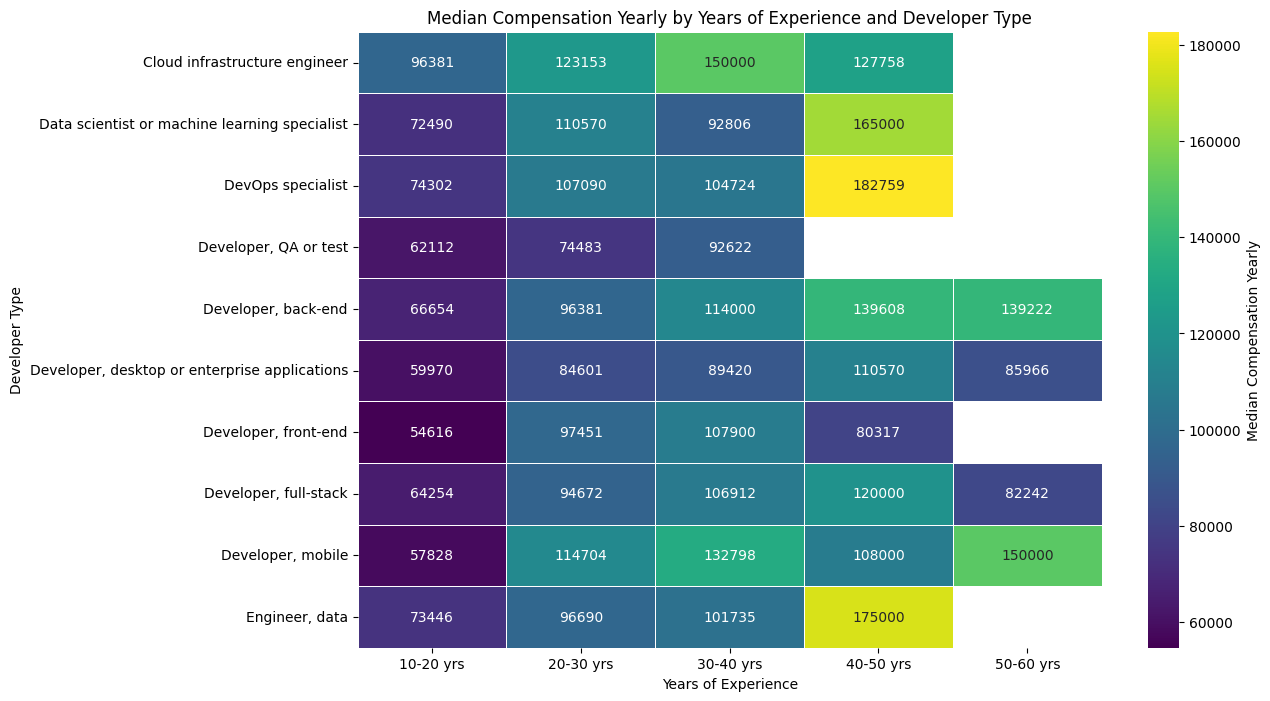

In [ ]:
dev_df = df[['DevType', 'WorkExp', 'ConvertedCompYearly']]
dev_df = dev_df[dev_df['DevType'].isin(dev_list)]
dev_df['YrsExp'] = dev_df['WorkExp'].apply(get_exp_group)

median_salary_by_workex = dev_df.groupby(['YrsExp', 'DevType'])['ConvertedCompYearly'].median().reset_index()
median_salary_by_workex.columns = ['YrsExp', 'DevType', 'MedianSalary']

df_emp_new = pd.merge(dev_df, median_salary_by_workex, on=['YrsExp', 'DevType'], how='left')

heatmap_data = df_emp_new.pivot_table(values='MedianSalary', index='DevType', columns='YrsExp', aggfunc='median')
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Median Compensation Yearly'})
plt.title('Median Compensation Yearly by Years of Experience and Developer Type')
plt.xlabel('Years of Experience')
plt.ylabel('Developer Type')
plt.show()

In [ ]:
df_education = df[['EdLevel','ConvertedCompYearly']]
df_education['Education Level'] = df_education['EdLevel'].apply(get_education_details)

In [ ]:
from scipy.stats import chi2_contingency
df_business = df[['EdLevel','CodingActivities']]
df_business['Education Level'] = df_business['EdLevel'].apply(get_education_details)
df_business['BootstrappingBusiness'] = df_business['CodingActivities'].str.contains("Bootstrapping")

contingency_table = pd.crosstab(df_business['Education Level'], df_business['BootstrappingBusiness'])


chi2, p, _, _ = chi2_contingency(contingency_table)


print(f"Chi-square value: {chi2}")
print(f"P-value: {p}")


alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant association.")
else:
    print("Fail to reject the null hypothesis: No significant association.")

Chi-square value: 79.51567602954458
P-value: 1.0596638111437259e-15
Reject the null hypothesis: There is a significant association.


In [ ]:
from statsmodels.stats.weightstats import ztest
df_education = df[['EdLevel','ConvertedCompYearly', 'WorkExp']]
df_education['Education Level'] = df_education['EdLevel'].apply(get_education_details)

df_masters = df_education[df_education['Education Level'] == "Master’s"]
df_bachelors = df_education[df_education['Education Level'] == "Bachelor’s"]


z_stat, p_value = ztest(df_masters['ConvertedCompYearly'], df_bachelors['ConvertedCompYearly'], alternative='larger')


print("Independent t-test Result:")
print("T-statistic:", z_stat)
print("P-value:", p_value)


alpha = 0.05
if p_value < alpha:
    print("Master's > Bachelor's groups.")
else:
    print("Compensation between Master's < Bachelor's groups.")

Independent t-test Result:
T-statistic: -0.35521103244247576
P-value: 0.6387842498633547
Compensation between Master's < Bachelor's groups.


In [ ]:
from statsmodels.stats.weightstats import ztest
df_opensource = df[['CodingActivities', 'ConvertedCompYearly']]
df_opensource['OpenSourceContributor'] = df_opensource['CodingActivities'].str.contains('Contribute to open-source projects')


df_contributors = df_opensource[df_opensource['OpenSourceContributor']]
df_non_contributors = df_opensource[~df_opensource['OpenSourceContributor']]


z_stat, p_value = ztest(df_contributors['ConvertedCompYearly'], df_non_contributors['ConvertedCompYearly'], alternative='larger')


print("Independent One Tail z-test Result:")
print("Z-statistic:", z_stat)
print("P-value:", p_value)


alpha = 0.05
if p_value < alpha:
    print("compensation between open-source contributors > non-contributors.")
else:
    print("compensation between open-source contributors < non-contributors.")

Independent One Tail z-test Result:
Z-statistic: 9.486718574055542
P-value: 1.1921072898777646e-21
compensation between open-source contributors > non-contributors.


In [ ]:
df_hobbies = df[['CodingActivities', 'ConvertedCompYearly']]
df_hobbies['Hobbies'] = df_hobbies['CodingActivities'].str.contains('Hobby')


df_hobbies_yes = df_hobbies[df_hobbies['Hobbies']]
df_non_hobbies = df_hobbies[~df_hobbies['Hobbies']]


z_stat, p_value = ztest(df_hobbies_yes['ConvertedCompYearly'], df_non_hobbies['ConvertedCompYearly'], alternative='larger')


print("Independent One Tail z-test Result:")
print("Z-statistic:", z_stat)
print("P-value:", p_value)


alpha = 0.05
if p_value < alpha:
    print("compensation between hobbies > non-hobbies.")
else:
    print("compensation between hobbies < non-hobbies.")

Independent One Tail z-test Result:
Z-statistic: 5.989307957927045
P-value: 1.0536790053720529e-09
compensation between hobbies > non-hobbies.


In [ ]:
from scipy.stats import chi2_contingency
df_codeactvt = df[['CodingActivities', 'DevType']]
df_codeactvt['CodingActivities'] = df_codeactvt['CodingActivities'].str.split(";")
df_codeactvt = df_codeactvt.explode('CodingActivities')


contingency_table = pd.crosstab(df_codeactvt['CodingActivities'], df_codeactvt['DevType'])



chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)


print("Chi-Square Test Result:")
print("Chi2 Statistic:", chi2_stat)
print("P-value:", p_value)


alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant relationship between coding activities and developer type.")
else:
    print("There is no statistically significant relationship between coding activities and developer type.")

Chi-Square Test Result:
Chi2 Statistic: 1503.371602893134
P-value: 4.0744823975276306e-188
There is a statistically significant relationship between coding activities and developer type.


In [ ]:

from scipy import stats
from statsmodels.stats.weightstats import ztest

df_emp = df[['Employment', 'ConvertedCompYearly']]
df_emp['Emp'] = df_emp['Employment'].apply(get_employement)

full_time_salary = df_emp[df_emp['Emp'] == 'Full Time']['ConvertedCompYearly']
part_time_salary = df_emp[df_emp['Emp'] == 'Part Time']['ConvertedCompYearly']


full_time_salary = full_time_salary.dropna()
part_time_salary = part_time_salary.dropna()


z_stat, p_value = ztest(full_time_salary, part_time_salary, alternative='larger')

print("Independent One Tail z-test Result:")
print("Z-statistic:", z_stat)
print("P-value:", p_value)


alpha = 0.05


if p_value < alpha:
    print("Reject the null hypothesis: Full-time developers earn more on average than Part Time developers.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average earnings between full-time and Part Time developers.")

Independent One Tail z-test Result:
Z-statistic: 10.091102439656867
P-value: 3.02431705053906e-24
Reject the null hypothesis: Full-time developers earn more on average than Part Time developers.


In [ ]:

from scipy import stats
from statsmodels.stats.weightstats import ztest

df_emp = df[['Employment', 'ConvertedCompYearly']]
df_emp['Emp'] = df_emp['Employment'].apply(get_employement)

full_time_salary = df_emp[df_emp['Emp'] == 'Full Time']['ConvertedCompYearly']
freelance_salary = df_emp[df_emp['Emp'] == 'Freelancer']['ConvertedCompYearly']


full_time_salary = full_time_salary.dropna()
freelance_salary = freelance_salary.dropna()


z_stat, p_value = ztest(full_time_salary, freelance_salary, alternative='larger')

print("Independent One Tail z-test Result:")
print("Z-statistic:", z_stat)
print("P-value:", p_value)


alpha = 0.05


if p_value < alpha:
    print("Reject the null hypothesis: Full-time developers earn more on average than Freelancers.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average earnings between Full-time developers and Freelancers.")

Independent One Tail z-test Result:
Z-statistic: -1.8482204613656088
P-value: 0.9677147717162318
Fail to reject the null hypothesis: No significant difference in average earnings between Full-time developers and Freelancers.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
dfdev = df[['DevType', 'CodingActivities']]
dfdev = dfdev[dfdev['DevType'].isin(['Developer, full-stack','Cloud infrastructure engineer'])]
dfdev['ContributeToOpenSource'] = dfdev['CodingActivities'].str.contains('open-source')

dev_type_full_stack = 'Developer, full-stack'
dev_type_cloud_architect = 'Cloud infrastructure engineer'


contingency_table = pd.crosstab(dfdev['DevType'], dfdev['ContributeToOpenSource'])


count_full_stack_open_source = contingency_table.loc[dev_type_full_stack, True]
count_cloud_architect_open_source = contingency_table.loc[dev_type_cloud_architect, True]


total_full_stack = contingency_table.loc[dev_type_full_stack].sum()
total_cloud_architect = contingency_table.loc[dev_type_cloud_architect].sum()


stat_full_stack, p_value_full_stack = proportions_ztest([count_full_stack_open_source, count_cloud_architect_open_source],
                                                        [total_full_stack, total_cloud_architect])
print("Propotions z-test Result:")
print("Z-statistic:", stat_full_stack)
print("P-value:", p_value_full_stack)


alpha = 0.05
if p_value_full_stack < alpha:
    print(f"The difference in proportions for {dev_type_full_stack} and {dev_type_cloud_architect} in open-source contribution is statistically significant.")
else:
    print(f"The difference in proportions for {dev_type_full_stack} and {dev_type_cloud_architect} in open-source contribution is not statistically significant.")

Propotions z-test Result:
Z-statistic: -4.226121881933065
P-value: 2.3775324882538933e-05
The difference in proportions for Developer, full-stack and Cloud infrastructure engineer in open-source contribution is statistically significant.
